___
## Delay specific decoder
___

In [16]:
path_to_data = r'C:\Users\tiffany.ona\Documents\Ephys\summary_complete'
save_data = r'G:\My Drive\WORKING_MEMORY\PAPER\2ND_SUBMISSION_NAT_NEURO\data_for_resubmission'
save_figures = r'G:\My Drive\WORKING_MEMORY\PAPER\2ND_SUBMISSION_NAT_NEURO\figures_for_resubmission'

In [2]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import os 
import pandas as pd
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt

import sys
sys.path.append("G:/My Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/ANALYSIS/src/functions/")
import ephys_functions as ephys
import model_functions as mod
import behavioral_functions as beh

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings. filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None  # default='warn'


**Functions**

In [39]:
def interval_extraction_trial(df, cluster_list=[], variable = 'vector_answer', align = 'Delay_OFF', start = 0, stop = 1, delay_only=False):
    y = []
    d = {}
    
    if delay_only == False:
        # print('Skipping delays')
        if align == 'Delay_OFF' and start < 0:
            df = df.loc[(df.delay != 0.1) & (df.delay != 0.2)]
        if align == 'Delay_OFF' and start < -1:
            df = df.loc[(df.delay != 0.1) & (df.delay != 0.2) & (df.delay != 1)]

        if align == 'Stimulus_ON' and stop > 0.5:
            df = df.loc[(df.delay != 0.1) & (df.delay != 0.2)]

        if align == 'Stimulus_ON' and stop > 1.5:
            df = df.loc[(df.delay != 0.1) & (df.delay != 0.2) & (df.delay != 1)]
    
    # print('Recovered from: ', str(len(df.trial.unique())), ' trials')
    # Create new aligment to the end of the session
    df['a_'+align] = df.fixed_times-df[align]

    # cluster_list = df_all.cluster_id.unique()
    df = df.sort_values('trial')
    
    y = df.groupby('trial')[variable].mean()

    # Filter for the spikes that occur in the interval we are analyzing
    df = df.loc[(df['a_'+align]>start)&(df['a_'+align]<stop)]

    df_final = pd.DataFrame()
    df_final = df.groupby(['trial','cluster_id']).count()
    df_final.reset_index(inplace=True)
    df_final = df_final.pivot_table(index=['trial'], columns='cluster_id', values='fixed_times', fill_value=0).rename_axis(None, axis=1)
    df_final = df_final.reindex(cluster_list, axis=1,fill_value=0)

    result = pd.merge(df_final, y, how="right", on=["trial"]).fillna(0)
    result = result.rename(columns={variable: "y"})
    result['y'] = np.where(result['y'] == 0, -1, result['y']) 
    
    return result, result['y']

In [37]:
def train(df, decode='vector_answer', align='Delay_OFF', start=-0.5, stop=0, cluster_list = [], ratio=0.65, test_index=[],  train_index=[], fakey=[], delay_only=False):

    df_final, y = interval_extraction_trial(df,variable = decode, align = 'Stimulus_ON', start = -0.25, stop = 0, cluster_list = cluster_list, delay_only=delay_only)
    sc = RobustScaler()
    x =df_final.iloc[:, df_final.columns != 'y']
    sc_fit = sc.fit(x)
    
    df_final, y = interval_extraction_trial(df,variable = decode, align = align, start = start, stop = stop, cluster_list = cluster_list, delay_only=delay_only)
    
    # This is mainly for the session shuffles
    if len(fakey) > 1:
        print('Using shuffled session')
        y = fakey[len(fakey)-len(y):]
        df_final['y'] = y   
        
    train_cols = df_final.columns
    
    #Train the model   
    df_final.reset_index(inplace=True)
    df_final = df_final.drop(columns ='trial')
    
    if len(test_index) >= 1:
        print('Using splits')
        train = df_final.loc[train_index,:]
        test = df_final.loc[test_index,:]
        # print('Fold',str(fold_no),'Class Ratio:',sum(test['y'])/len(test['y']))
        x_test = test.iloc[:, test.columns != 'y']
        y_test = test['y']
        x_train = train.iloc[:, train.columns != 'y']
        y_train = train['y']
        
    else:
        x_train = df_final.iloc[:, df_final.columns != 'y']
        y_train = df_final['y']
        x_test = x_train
        y_test = y_train
        
    #Normalize the X data
    sc = RobustScaler()
    sc_fit = sc.fit(df_final.iloc[:, df_final.columns != 'y'])
    
    # x_train = sc.fit_transform(x_train)
    # x_test = sc.fit_transform(x_test)
    
    x_train = sc_fit.transform(x_train)
    x_test = sc_fit.transform(x_test)
    
    from sklearn.model_selection import GridSearchCV
    param_grid = {
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10]
    }
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    grid.fit(x_train, y_train)
    print(grid.best_params_)

    model = LogisticRegression(solver='liblinear', penalty = 'l1').fit(x_train, y_train)
    # model = LogisticRegression(solver='liblinear', penalty = 'l1', C=0.95, fit_intercept=True).fit(x_train, y_train)
    train_cols = df_final.columns
    
    p_pred = model.predict_proba(x_test)    
    y_pred = model.predict(x_test)    
    f1score= f1_score(y_test, y_pred, average='weighted')

    y_test = np.where(y_test == -1, 0, y_test) 
    y_new = y_test.reshape(len(y_test), 1).astype(int)
    # y_new = y_test.values.reshape(len(y_test), 1).astype(int)
    score_ =  np.take_along_axis(p_pred,y_new,axis=1)   

    # print('Trained model on ', len(train_cols), ' neurons.')
    print('score:', np.mean(score_), 'f1_score ', f1score)
    
    return model, train_cols, np.mean(score_), sc_fit

In [38]:
def test(df,sc_fit, epoch='Stimulus_ON',initrange=-0.4,endrange=1.5,r=0.2, model = None, train_cols=None, variable='ra_accuracy',
                      hit=1, nsurrogates = 100, decode='vector_answer', ratio=0, cluster_list = [], test_index=[], fakey=[], delay_only=False):
    '''
    Function that tests a previously trained function (func. train_decoder) on population activity of specific segments
    
    Attributes
        - df: DataFrame. it contains a whole ephys session without curation. 
        - WM and RL are the variables to consider a trial in the RL or in the WM-module. Both need to be floats. 
        - epoch: str. Moment at which the data will be aligned to. 
        - initrange: float. 
        - endrange: float.
        - r: float 
        - model. function. 
        - train_cols
        - name. String
        - variables. List. 
        - hits. List. 
        - colors. List
        - nsurrogates. Int. 
        - indexes. List 
        - decode. String
    
    Return
        - df_real
        - df_iter
        It will also make a plot. 
    '''
    
    df_real = pd.DataFrame()
    df_iter = pd.DataFrame(columns=['iteration', 'score', 'times', 'epoch', 'variable'])
        
    times = [] # Timestamps
    real_score = [] # real scoring of the decoded
    mean_sur=[] # mean of the surrogate data

    for start, stop in zip(np.arange(initrange,endrange-r,r/2),np.arange(initrange+r,endrange,r/2)):
        times.append((start+stop)/2)
        df_final, y = interval_extraction_trial(df,variable = decode, align = epoch, start = start, stop = stop, cluster_list=cluster_list, delay_only=delay_only)

        # Sometimes the testing and the trainind dataset have different neurons since they are looking at different trials and perhaps there were no spikes
        # coming from all neurons. We compare which columns are missing and add them containing 0 for the model to work. 
        test_cols = df_final.columns
        common_cols = train_cols.intersection(test_cols)
        train_not_test = train_cols.difference(test_cols)
        for col in train_not_test:
            df_final[col] = 0

        #The other way round. When training in segmented data, sometimes the training set is smaller than the testing (for instance, when training in Hb trials and testing in WM)
        test_not_train = test_cols.difference(train_cols)
        for col in test_not_train:
            df_final.drop(columns=[col],inplace=True)

        #Train the model"
        if len(test_index) >= 1:
            print('Train splitting trials')
            # Split data in training and testing
            # x_train, x_test, y_train, y_test =\
            #     train_test_split(df_final, y, test_size=test_sample,random_state=random_state)
            
            df_final.reset_index(inplace=True)
            df_final = df_final.drop(columns ='trial')
            test = df_final.loc[test_index,:]
            # print('Fold',str(fold_no),'Class Ratio:',sum(test['y'])/len(test['y']))
            x_test = test.iloc[:, test.columns != 'y']
            y_test = test['y']             

        else:
            x_train = df_final.iloc[:, df_final.columns != 'y']
            y_train = df_final['y']
            x_test = x_train
            y_test = y_train
        
        #Normalize the X data
        # sc = RobustScaler()
        # x_test = sc.fit_transform(x_test)
        # x_test = sc_fit.transform(x_test)
        
        p_pred = model.predict_proba(x_test)
        y_pred = model.predict(x_test)
        score_ = model.score(x_test, y_test)
        real_score.append(score_)

        # y_test = np.where(y_test == -1, 0, y_test) 
        # y_new = y_test.reshape(len(y_test), 1).astype(int)
        # corrected_score =  np.take_along_axis(p_pred,y_new,axis=1)   
        # real_score.append(np.mean(corrected_score))

        # print('score:', score_, 'corrected score: ', np.mean(corrected_score), end='\n\n')

        i=0
        rows = []
        while i <= nsurrogates:
            i+=1
            y_perr = shuffle(y_test)
            score_ = model.score(x_test, y_perr)

            # y_new = y_perr.reshape(len(y_perr), 1).astype(int)
            # result =  np.take_along_axis(p_pred,y_new,axis=1)     
            # score_  = np.mean(result)

            new_row = pd.DataFrame({'iteration': [i], 'score': [score_], 'times': [(start+stop)/2], 'epoch' : [epoch], 
                                      'variable' : [variable+'_'+str(hit)]})
            df_iter = pd.concat([df_iter,new_row], ignore_index=True)
        
    times.append('trial_type')
    real_score.append(variable+'_'+str(hit))
    a_series = pd.DataFrame([real_score], columns = times)

    df_real = pd.concat([df_real,a_series], ignore_index=True)
    
    return df_real, df_iter

_________________________________________
#### **Train in one delay and test in other delays**

In [ ]:
## Dataframe used for cumulative analysis
df_cum = pd.DataFrame()
df_cum_shuffle = pd.DataFrame()

os.chdir(path_to_data)
for filename in os.listdir(os.getcwd()):
# for filename in list_of_sessions:
    # 
    if filename[-3:] != 'pdf':
        df = pd.read_csv(filename, sep=',',index_col=0)
    else:
        continue
        
    print(filename, '/ Total session trials: ', len(df.trial.unique()), '/ Number of neurons: ', len(df.cluster_id.unique()))
    
    df = ephys.add_time_before_stimulus(df, 4)

    substract = True
    df['delay'] = np.around(df.delay,2)
    
    # Variables used for decoder training
    decode = 'vector_answer'
    align='Delay_OFF'
    ratio = 0.6
    delay_train = 'all'
    start = -0.5
    stop = 0
    type_trial ='WM_roll'
    hit = 1
    nsplits = 5
    
    #Variables for testing
    colors=['darkgreen','orangered']
    variables = ['WM_roll','WM_roll']
    hits = [1,1]
    ratios = [0.6,0.6]
    delays = [3, 10]
    variables_combined=[variables[0]+'_'+str(hits[0]),variables[1]+'_'+str(hits[1])]

    # colors=['crimson','darkgreen','indigo','purple']
    # variables = ['WM_roll','WM_roll','RL_roll','RL_roll']
    # hits = [0,1,1,0]
    # ratios = [0.6,0.6,0.4,0.4]
    # variables_combined=[variables[0]+'_'+str(hits[0]),variables[1]+'_'+str(hits[1]),variables[2]+'_'+str(hits[2]),variables[3]+'_'+str(hits[3])]

    cluster_list = df.cluster_id.unique()

    skf = StratifiedKFold(n_splits=nsplits, shuffle=True)
    # skf = KFold(n_splits=nsplits, shuffle=True)

    # Create a dataframe for training data
    if type_trial == 'all':
        df_train = df.loc[(df.hit==hit)]
    elif hit == 'all':
        df_train = df.loc[(df[type_trial]>=ratio)]
    else:
        df_train = df.loc[(df[type_trial]>=ratio)&(df.hit==hit)]

    if delay_train != 'all':
        df_train = df_train.loc[(df_train.delay==delay_train)]
    else:
        df_train = df_train.loc[(df_train.delay!=0.2)&(df_train.delay!=0.1)]
        
    df_final, y = interval_extraction_trial(df_train, variable = decode, align = align, start = start, stop = stop, cluster_list=cluster_list)
    df_final.reset_index(inplace=True)
    df_final = df_final.drop(columns ='trial')
    
    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import Pipeline

    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_final, y, test_size=0.2, random_state=42)

    # Define a pipeline for scaling and logistic regression
    pipeline = Pipeline([
        ('scaler', RobustScaler()),  # Standardize features
        ('logreg', LogisticRegression(max_iter=500))  # Logistic Regression
    ])

    # Define the parameter grid
    param_grid = {
        'logreg__solver': ['liblinear', 'saga'],  # Solvers to test
        'logreg__penalty': ['l1', 'l2'],          # Regularization types
        'logreg__C': [0.01, 0.1, 1, 10, 100]     # Regularization strength
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and corresponding score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validated Accuracy:", grid_search.best_score_)

    # Evaluate the model on the test set
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Test Set Accuracy:", test_score)

    fold_no = 1
    if len(y) < nsplits:
        print('Skip session because not enough trials')
        continue
        
    for train_index, test_index in skf.split(df_final, y):
        print('Fold_no:', fold_no)
        model, train_cols, score, sc_fit = train(df_train, decode=decode, align=align, start=start,stop=stop, cluster_list = cluster_list, 
                                  test_index=test_index,  train_index=train_index)

        # Remove a fifth of the dataset so it can be compared to crossvalidated data. If we want to randomly reduce it, add reduce to trian function
        # drop_list = np.array_split(df_train.trial.unique(), 5)[fold_no]
        # df_train = df_train[~df_train['trial'].isin(drop_list)]
        # index_train_trials = df_train.trial.unique()
        # print('Total of left: ', len(df_train.loc[df_train['vector_answer'] == 0].groupby('trial').mean()), '; Total of right: ', len(df_train.loc[df_train['vector_answer'] == 1].groupby('trial').mean()))

        fig, ax1 = plt.subplots(1,1, figsize=(8, 4), sharey=True)

        for color, variable, delay, hit, ratio, left in zip(colors,variables, delays, hits,ratios,[ax1,ax1,ax1,ax1]):
            df_res = pd.DataFrame()
            df_sti = pd.DataFrame()
            df_iter = pd.DataFrame()
            try:
                df_delay = df.loc[np.around(df.delay,1)==delay]
                delay=np.around(df_delay.delay.iloc[0],1)
                print('Delay:', delay)
            except:
                pass

            if delay == 0.1 or delay == 0.2:
                endrange=3.5
                r=0.25

            elif delay == 1:
                endrange=4.5
                r=0.25

            elif delay == 3:
                endrange=6.5    
                r=0.25
                
            elif delay == 10:
                endrange=14.5
                r=0.25
            
            # Create a dataframe for testing data
            if variable == 'all':
                df_test = df_delay.loc[(df_delay.hit==hit)]
            elif hit == 'all':
                df_test = df_delay.loc[(df_delay[variable]>=ratio)]
            else:
                df_test = df_delay.loc[(df_delay[variable]>=ratio)&(df_delay.hit==hit)]
                
            if fold_no == 1:
                print(delay, variable, 'Threshold:', ratio, 'Hit:', hit, 'Nº of trials:', len(df_test.trial.unique()))

# -----------  Remove the trials that overlap with the training set.
            list_train_trials = df_train.trial.unique()[train_index]
            df_test = df_test[~df_test['trial'].isin(list_train_trials)] 
            
            if len(df_test.trial.unique())<5:
                print('Not enough trials with this condition')
                continue

            df_real,df_temp = test(df_test, sc_fit, decode= decode,epoch='Stimulus_ON',initrange=-2,endrange=endrange, r=r, model = model, delay_only=delay, variable=variable, hit=hit, nsurrogates = 100,train_cols = train_cols, cluster_list = cluster_list)

            df_sti = pd.concat([df_real,df_sti])
            df_iter = pd.concat([df_iter,df_temp])
            
            variable = str(variable)+'_'+str(hit)

            # Aligmnent for Stimulus cue
            real = df_sti.loc[(df_sti['trial_type'] ==variable)].to_numpy()
            times = np.around(np.array(df_sti.columns)[:-1].astype(float),2)

            df_new= df_iter.loc[(df_iter.epoch=='Stimulus_ON')].groupby('times')['score']
            y_mean= df_new.mean().values
            lower =  df_new.quantile(q=0.975, interpolation='linear') - y_mean
            upper =  df_new.quantile(q=0.025, interpolation='linear') - y_mean
            x=times
            
            ephys.plot_results_decoder(fig, real[0][:len(y_mean)], times, df_new,  ax1, color = color, epoch = 'Delay_OFF', 
                        y_range = [-0.05, 0.5], x_range = None, substract=True)
            
            df_cum, df_cum_shuffle = ephys.add_to_summary(real[0][:len(y_mean)], y_mean, times, filename, variable, epoch = 'Stimulus_ON', fold_no=fold_no, df_iter=df_iter, df_cum=df_cum, df_cum_shuffle=df_cum_shuffle, substract=False, delay=delay)
            
            sns.despine()
            
        fold_no+=1
        plt.tight_layout()
        plt.show()


E04_2021-03-30_11-20-16.csv / Total session trials:  191 / Number of neurons:  11
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [41]:
df_cum['trial_type'] = np.where(df_cum['delay'] == 3, 'WM_3', 'WM_10')

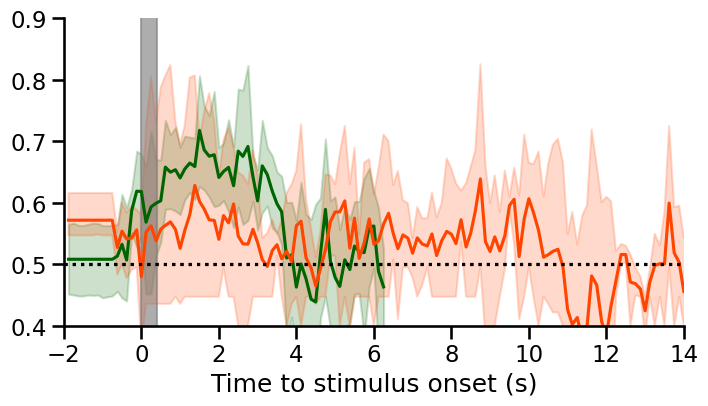

In [42]:
fig, ax = plt.subplots(1,1, figsize=(8, 4), sharey=True)

ephys.plot_results_session_summary(ax, df_cum, colors, variables_combined = ['WM_3', 'WM_10'], 
                                 y_range = [0.4, 0.9], x_range = [-2, 14], epoch = 'Stimulus_ON', baseline=0.5)

In [25]:
pl = df_cum.groupby('session').delay.mean()
pl = pl.reset_index()

pl['all_trials']  = np.where(pl['delay'] == 10, False, True)
list_sessions = pl.loc[pl.all_trials == True].session.unique()

df_cum = df_cum.loc[df_cum.session.isin(list_sessions)]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 4), sharey=True)
ephys.plot_results_session_summary_substract(fig, ax, df_cum, df_cum_shuffle, color='darkgreen', variable='WM_roll_1', y_range = [-0.05, 0.3], x_range = None, epoch = 'Stimulus_ON', baseline=0.5)

In [41]:
# save_path = 'G:/My Drive/WORKING_MEMORY/PAPER/ANALYSIS_figures/'
# os.chdir(save_path)

file_name = 'review_crossdelay_decoder_train3'
df_cum.to_csv(file_name+'.csv')
